#  Perfilamiento clientes: Feature engineering y modelo

### Contexto

A continuación, se presenta la metodología utilizada para la implementación de un modelo de segmentación de clientes según datos personales como edad, niveles de estudio, situación civil e ingresos; además, de comportamientos con ciertos productos, preferencias hacia ellos así como medios más utilizados para realizar compras. 


### Origen dataset

La información con la que se trabajó es pública y fue tomada de kaggle : https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?resource=download

#### - Melissa Mejía Villamil

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

# para el feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [2]:
data = pd.read_csv('clients_info.csv')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,Single,58138.0,0,0,09/04/12,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,Graduation,Single,46344.0,1,1,03/08/14,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,Graduation,Together,71613.0,0,0,08/06/13,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,Graduation,Together,26646.0,1,0,02/10/14,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,PhD,Married,58293.0,1,0,19/01/2014,94,173,43,118,46,27,15,5,5,3,6,5


In [3]:
# Transformaciones del df previas al preprocesamiento
today = datetime.datetime.now()
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['Year_Enrolled'] = (data['Dt_Customer'] - today)/360
data['Year_Enrolled'] = abs(data['Year_Enrolled'].dt.days)
data['Age'] = today.year - data['Year_Birth']

#### Búsqueda de variables caterógicas
Aquí me encargo de buscar las variables 'cualitativas' de mi dataset para transformarlas

In [4]:
categorical = [var for var in data.columns if data[var].dtype=='O']

print('Existen {} variables categóricas'.format(len(categorical)))

Existen 2 variables categóricas


In [5]:
data[categorical].head()

,Education,Marital_Status
0,Graduation,Single
1,Graduation,Single
2,Graduation,Together
3,Graduation,Together
4,PhD,Married


In [6]:
# Encuentro las variables numéricas
numerical = [var for var in data.columns if data[var].dtype!='O']
# Busco las que contienen información relativa a años
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]
year_vars

['Year_Birth', 'Year_Enrolled']

In [7]:
data[year_vars].head()

,Year_Birth,Year_Enrolled
0,1957,11
1,1954,10
2,1965,10
3,1984,10
4,1981,10


#### Find discrete variables
Aquí enceuntro las variables discretas.

In [8]:
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('Existen {} variables discretas'.format(len(discrete)))

Kidhome  values:  [0 1 2]
Teenhome  values:  [0 1 2]
NumDealsPurchases  values:  [ 3  2  1  5  4 15  7  0  6  9 12  8 10 13 11]
NumWebPurchases  values:  [ 8  1  2  5  6  7  4  3 11  0 27 10  9 23 25]
NumCatalogPurchases  values:  [10  1  2  0  3  4  6 28  9  5  8  7 11 22]
NumStorePurchases  values:  [ 4  2 10  6  7  0  3  8  5 12  9 13 11  1]
NumWebVisitsMonth  values:  [ 7  5  4  6  8  9 20  2  3  1 10  0 14 19 17 13]

Existen 7 variables discretas


#### Continuous variables
Aquí me encargo de las variables que son continuas

In [9]:
numerical = [var for var in numerical if var not in discrete and var not in [
    'ID', 'Dt_Customer'] and var not in year_vars]
print('Existen {} variables numéricas y continuas'.format(len(numerical)))

Existen 9 variables numéricas y continuas


#### Missing values
Me encargo de llenar los valores que estén vacíios en el dataset

In [10]:
# Revisamos la calidad del dataset calculando el porcentaje de vacíos que tenemos

for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

Income 0.010714285714285714


#### Outliers and distributions
Revisamos los valores atípicos y la distribución de los datos del dataset

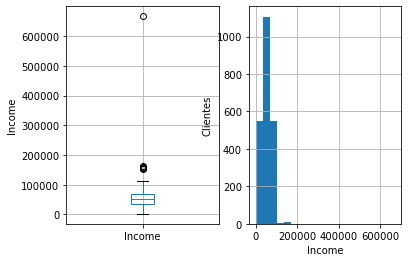

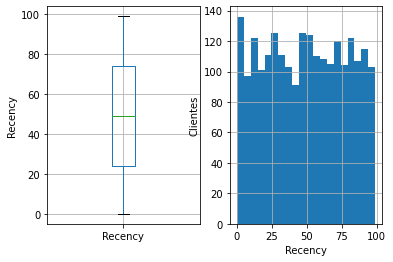

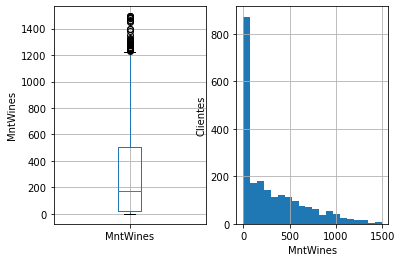

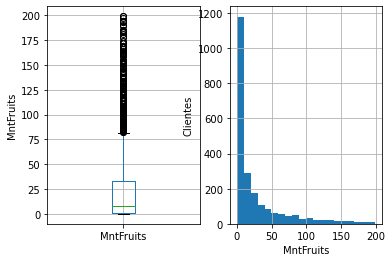

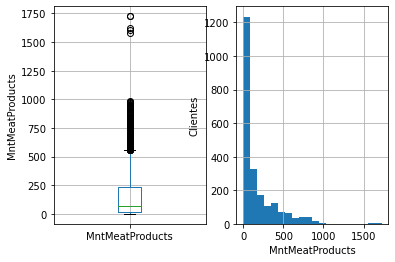

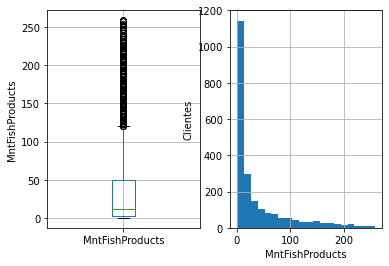

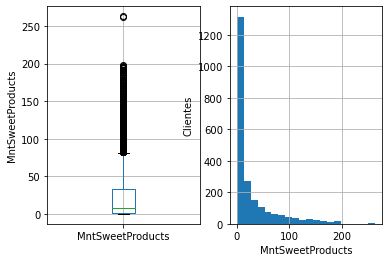

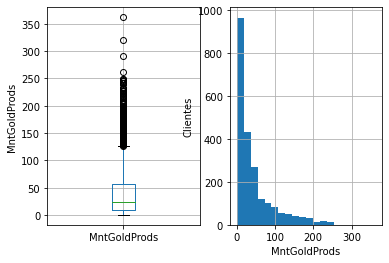

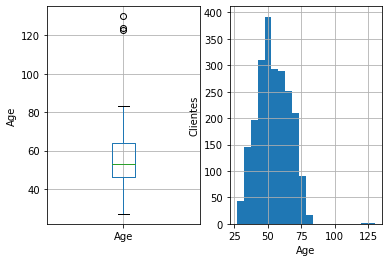

In [11]:
for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Clientes')
    fig.set_xlabel(var)

    plt.show()

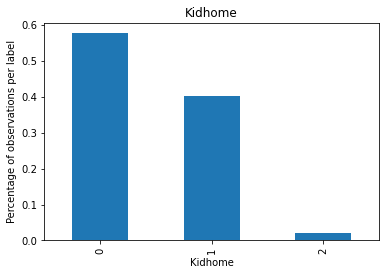

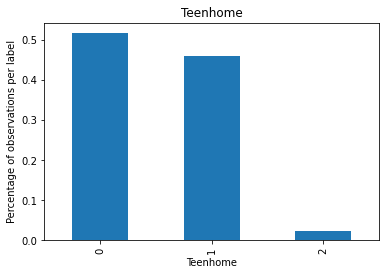

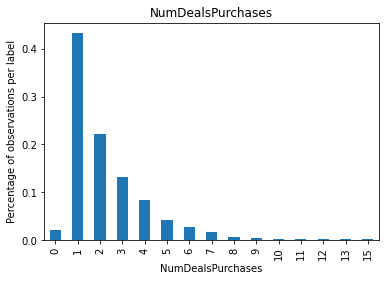

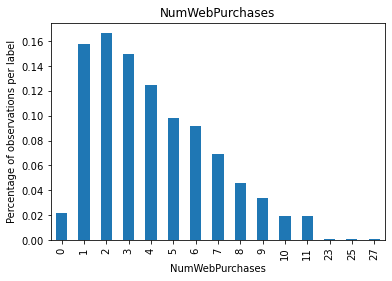

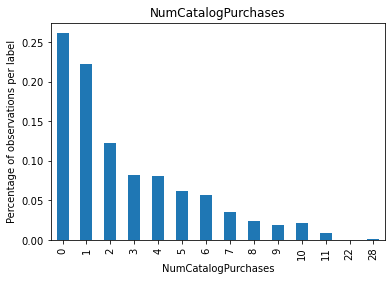

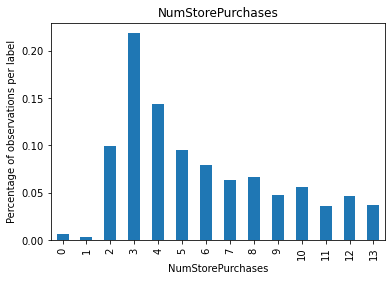

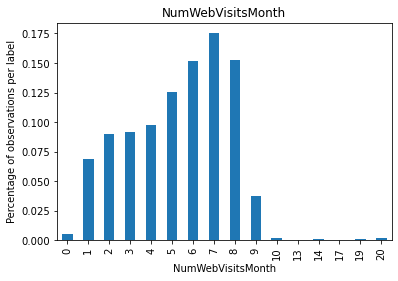

In [12]:
# outlies in discrete variables

for var in discrete:
    (data.groupby(var)[var].count() / len(data)).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Text(0, 0.5, 'Number of different categories')

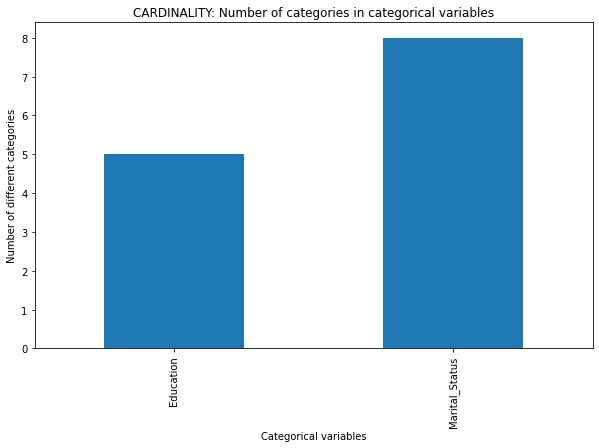

In [13]:
data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [14]:
# Preparamos el set de entrenamiento y de prueba. 
# Ignoramos las columnas con datos innecesarios para el modelo.

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['ID', 'Dt_Customer'], axis=1),
    data['ID'],
    test_size=0.1,
    random_state=0)

X_train.shape, X_test.shape

((2016, 20), (224, 20))

In [15]:
# Calculamos nuevamente porcentaje de datos faltantes
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

Income 0.009424603174603174


In [16]:
# Imprimimos las variables de los datos faltantes

for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

In [17]:
# Convertimos las variables discretas en categóricas
# Para ello, las re-casteamos como objetos.
X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [18]:
# Creo un pipeline con el fin de tener un modelo de feature-engineering
# y que el procesamiento del dataset no represente mayor gasto computacional
client_pipe = Pipeline([

    # missing data imputation - section 5
    ('missing_ind', mdi.AddMissingIndicator(
        variables=['Income'])),
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=['Income'])),
    
    ('imputer_cat', mdi.CategoricalImputer(variables=categorical)),

    # categorical encoding - section 7-10
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=categorical+discrete)),
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretisation + encoding - section 12
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=numerical)),

    # feature Scaling - section 18
    ('scaler', StandardScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])

In [19]:
# Ajustamos el pipeline
client_pipe.fit(X_train, y_train)

# Obtenemos las predicciones
X_train_preds = client_pipe.predict(X_train)
X_test_preds = client_pipe.predict(X_test)

Text(0, 0.5, 'Predicted value')

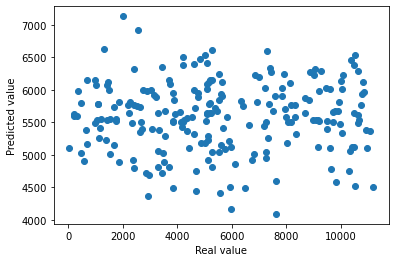

In [20]:
plt.scatter(y_test,X_test_preds)
plt.xlabel('Real value')
plt.ylabel('Predicted value')

<AxesSubplot:>

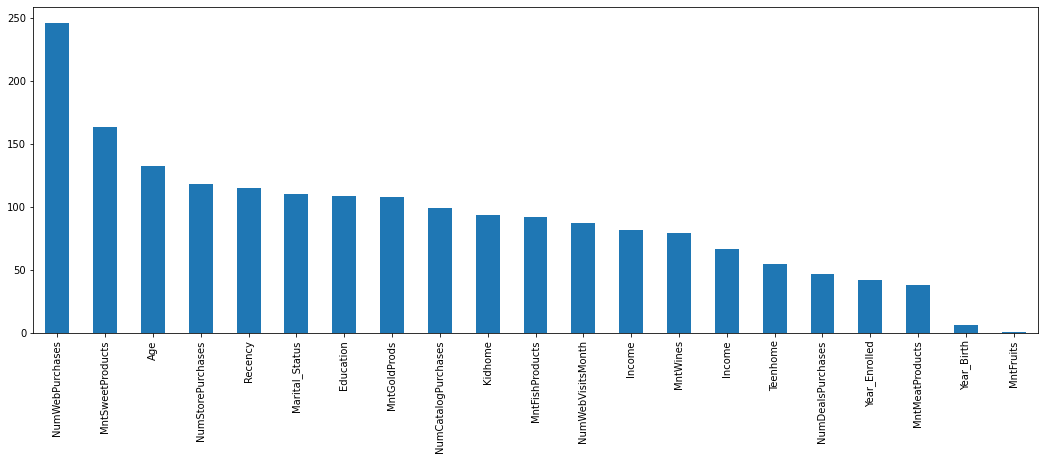

In [21]:
final_columns = X_train.columns
importance = pd.Series(client_pipe.named_steps['lasso'].coef_).abs()
importance.index = list(final_columns)+['Income']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

### Implementación de modelo de clúster KMeans
Se selecciona este método por la robustez escogida para el reto, buscando agilidad en la obtención de información relativa al perfilamiento de los clientes según sus actitudes, acciones y comportamientos.

In [31]:
import numpy as np
from sklearn.cluster import KMeans

In [32]:
#  Organizamos la información de entrenamiento para correr el modelo.
df = client_pipe.predict(X_train)
df = pd.DataFrame(df)

ValueError: The number of columns in this dataset is different from the one used to fit this transformer (when using the fit() method).

In [24]:
# Implementación del método de codo para seleccionar el parámetro K
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\skl

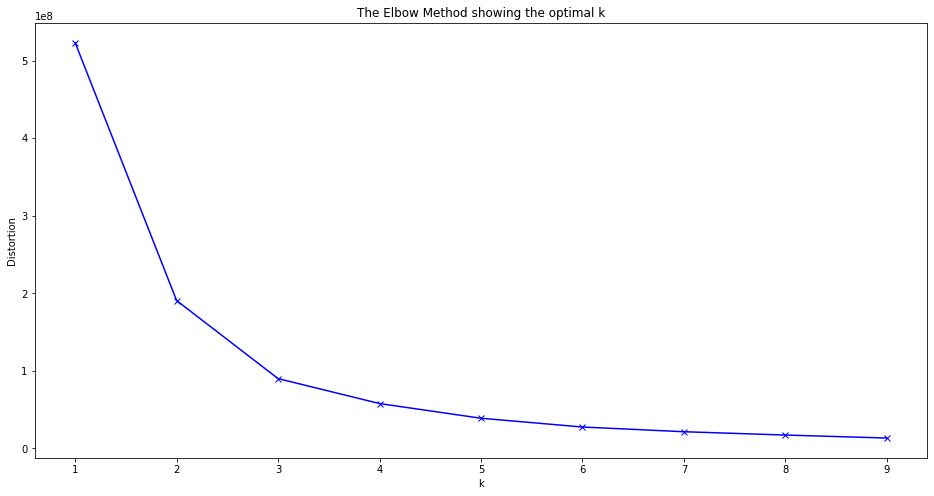

In [25]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [26]:
# Seleccionamos el valor 5
kmeanModel = KMeans(n_clusters=5)
y_kmeans = kmeanModel.fit_predict(df)

C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\MELISSA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [27]:
# Añadimos la clasificación del set de datos no procesados
# para facilitar su interpretación
X_train['cluster']= y_kmeans
X_test['cluster']= y_kmeans1

In [28]:
X = X_train.append(X_test, ignore_index=True)

In [29]:
X.to_csv('model_output.csv')